## Informacion
**Clase:** Redes Neuronales Artificiales

**Nombre:** Alejandro Duque

**Trabajo:** Parcial 1

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython import display

# Introduccion
En el presente trabajo se construirá un modelo Softmax para el reconocimiento de dígitos escritos a mano, se
utilizará las bases de datos semeion de imágenes binarias y mnist en escala de grises. En semeion cada dígito del
0 al 9 representa una clase, cada individuo está representado por 256 pixeles de una imagen binaria 16 × 16, donde
cero representa un pixel negro y 1 representa un pixel blanco. En mnist los datos son ya conocidos.

# Ejercicio
Lea el archivo semeion.csv , separe las primera 256 columnas en una matriz X y la últimas 10 columnas en una
matriz Y de 10 columnas. Tome una fila de la matrix binaria X y conviértala en una matriz 16 × 16, y dibuje el
dígito correspondiente. Repita el proceso eligiendo aleatoriamente 10 filas de X y mostrando el dígito respectivo al
que corresponde.

En cada fila de la matriz Y hay un solo uno, la posición que ocupa el 1 en la fila indica el dígito al cual
corresponde la imagen.

In [2]:
# Cargo el archivo
dataSemeion = np.array(pd.read_csv('./data/semeion.csv'))

In [3]:
# Genero las matrices X, Y
X = dataSemeion[:,:256]
Y = dataSemeion[:,-10:]

In [4]:
Y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

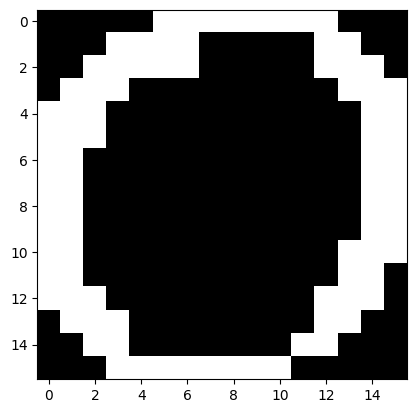

In [5]:
# Grafico la primera imagen
X1 = X[0,:]
img = np.reshape(X1, (16,16))
plt.imshow(img, cmap='gray')

# Generación de la Red Neuronal para clasificar dígitos.
Cada dígito representa una clase, por lo tanto hay 10 clases. El estímulo que produce cada individuo (fila de X) tiene una longitud que depende de la base, en el caso de semeion, la longitud es de 256. Vamos a imaginar 10 perceptrones o neuronas (1 por cada clase), cada uno con 257 intérpretes (pesos), para entender la estimulación de cada perceptrón, supongamos que el perceptrón de la clase 4 (correspondiente al dígito 4) tiene los pesos $w_{1,4} , w_{2,4} , \dotsc ,w_{256,4}, w_{257,4}$, entonces la interacción del iésimo individuo con el perceptrón de la clase 4 es $X_i^ \cdot W_4 = \sum_{j=1}^{257} x_{ij} w_{j4}$, donde $X_i^∗ = [ x_{i,1} \; x_{i,2} \; \dotsc \; x_{i,256} \; 1 ]$. La iteracción de cada individuo con cada perceptrón se calcularía a través del producto matricial $W*X^t$ , donde cada columna de $X^t$ es un individuo y cada fila de la matriz W son los pesos de un perceptrón.

Tomaremos como función de activación en el k-ésimo perceptrón a $f_k(z_k) = \frac{e^{z_k}}{e^{z_0} + e^{z_1} + \dotsc + e^{z_9}}$ , $k = 0, 1, \dotsc , 9$. donde $z_k$ es la interacción producida por un individuo en el k-ésimo perceptrón. Al vector columna de probabilidades
producido por las activaciones los denominaremos distribución estimada.

# Ejercicio
Programe una función *msoft* de Python, que evalúe el campo vectorial $F (x_1, x_2 , \dotsc, x_n ) = <f_1(x_1), \dotsc, f_n(x_n)>.$


In [6]:
# Z es el vector <x_1,...,x_n>
def msoft(Z):
    ExpZ = np.exp(Z)
    P = ExpZ / np.sum(ExpZ, axis=0)
    return P

Ahora compararemos el vector de probabilidades $p$ del iésimo individuo con su representación en la iésima fila de Y , para ello utilizaremos la función de pérdida $L _i(p) = −\sum_{k=0}^9 y_{ik} \log p_k$ (entropía cruzada ). El problema ahora es mínimizar el promedio de las entropias cruzadas producidas por $m$ individuos, es decir la función:
$$
E_p = -\frac{1}{m}\sum_{i=1}^m L_i(p)
$$


In [7]:
# Recibe la matriz P de probabilidades de output que genera la red
# y la matriz Y de labels conocidas
def entropiaCruzada(P, Y):
    Li = np.sum(np.transpose(Y) * np.log(P), axis=0)
    Ep = -np.average(Li)
    return Ep

# Problemas

##
Divida la base de datos semeion en dos grupos uno de entrenamiento y otro de prueba, tome 1200 elementos de manera aleatoria en el grupo de prueba, imprima los primeros 50 índices obtenidos de este grupo.

In [8]:
# Numero de imagenes en dataSemeion
numData = len(dataSemeion)

# Genero un ordenamiento aleatorio de indices
ind = np.arange(0, numData, dtype=int)
ind = np.random.permutation(ind)

# Selecciono indices para train y test
# La clase train debe ser mas grade que test
indTrain = ind[0:1200]
indTest = ind[1200:]

# Agrego el bias a X
X = np.c_[X, np.ones(1592)]

# Separo X en train y test
XTrain = X[indTrain]
XTest = X[indTest]

# Separo Y en train y test
YTrain = Y[indTrain]
YTest = Y[indTest]

# Imprimo los primeros 50 indices del grupo de prueba (test)
print(indTest[0:50])

[ 206  997 1557  171 1038  670  504 1015  316 1575 1025 1080   40 1211
 1443   71  995  155 1293  920 1313  470 1262  967 1304  552  755  441
 1072  532  616  226 1016 1545   15  305   95  889 1174  642  230 1231
  714  473  413  630  580  612  760  933]


Queda comprobado que la selección aleatoria de los índices si está funcionando.

##
Programe una función $mgrad$ para calcular el gradiente de $Ep$ con respecto de los pesos. Recuerde aplicar la regla de la cadena.

In [9]:
# Recibe el tensor de estimulos X, la matriz de labels que conocemos Y
# y las probabilidades de output que genera la red en P
def mgrad(X, Y, P):
    # Calculo las derivadas con respecto a todos los pesos
    # dLdZ es p - 1 cuando el individuo pertenece a la clase
    # dLdZ es p - 0 cuando el individuo no pertenece a la clase
    # Restar a P la transpuesta de Y cumple justo ese proposito
    dLdZ = P - np.transpose(Y)
    dZdW = X
    # Aplico la regla de la cadena
    dLdW = np.matmul(dLdZ, dZdW)
    return dLdW  

## 
Programe un función $redn$ en Python que use el método del gradiente descendiente, tomando subconjuntos (bunch o batch) de tamaño 50 y 50 épocas por defecto, para encontrar el conjunto de pesos que minimizan $E_p$. Realice experimentos variando el número de épocas hasta conseguir porcentajes de imágenes bien clasificadas mayores o iguales al 90% en cada clase sobre el conjunto de entrenamiento. La función debe devolver los pesos y el vector de pérdida total en cada iteración

In [10]:
# Ajusta los parametros de la red mediante descenso de gradiente
# Recibe el tensor de estimulos, la matriz Y de labels y el numero de pesos
def redn(X, Y, numParam, sizeBunch = 50, numEpoch = 50, step = 0.01, standarize = False):
    # Genero pesos aleatorios
    W = np.random.normal(size = numParam) 
    # Genero la particion que usaré para toda la búsqueda
    Partition = particionar(len(Y), sizeBunch)
    # Inicializo la perdida
    Loss = []
    # Ciclo de busqueda
    for i in range(numEpoch) :
        # Realizo un cubrimiento de la particion (Epoch)
        for bunch in Partition:
            # Capacidad interpretacion
            Z = np.matmul(W, np.transpose(X))
            # Estandarizo de ser necesario para evitar overflows
            if(standarize):
                Z = (Z - np.mean(Z))/ np.std(Z) * 3
            # Probabilidades obtenidas en softmax
            P = msoft(Z)
            # Gradiente
            grad = mgrad(X[bunch, :], Y[bunch, :], P[:, bunch])
            # Actualizo pesos
            W = W - step *  grad 
            # Calculo perdida en la iteracion
            Loss.append(entropiaCruzada(P, Y))
    # Evaluo la clasificacion
    probarClasificacion(P, Y)
    return(W, Loss)


# Genera una particion de los datos
def particionar(numData, sizeBunch):
    # Genero indices aleatorios
    ind = np.arange(0, numData, dtype=int)
    ind = np.random.permutation(ind) 
    # Creo la particion para cubrir el conjunto de los indices
    numBunch = numData // sizeBunch
    partition = []
    # Agrego elementos a la particion
    for i in range(numBunch):
        partition.append(ind[i*sizeBunch:(i+1)*sizeBunch])
    # Evaluo si la particion es regular
    sizeLastBunch = numData % sizeBunch
    # Si no es regular incluyo al ultimo el Bunch mas pequeño
    if(sizeLastBunch != 0):
        partition.append(ind[-sizeLastBunch:])
    return partition

# Clasifica usando validacion cruzada
def probarClasificacion(P, Y):
    # Clasificacion total
    PClass = np.argmax(P, axis = 0)
    YClass = np.argmax(Y, axis = 1)
    porcentaje = np.sum(PClass == YClass) * 100 / len(PClass)
    porcentaje = round(porcentaje, 2)
    print(f'Se clasificaron bien el {porcentaje}% de todas las imagenes\n')
    # Clasificacion por cada label
    print('Validacion cruzada:')
    for i in range(10):
        # Tomo los indices de la clase i y comparo con su clasificacion del modelo
        bien = np.sum(PClass[YClass == i] == i) * 100 / sum(YClass == i)
        bien = round(bien, 2)
        mal = round(100 - bien, 2)
        print(f'Porcentaje de la clase {i} bien clasificados: {bien}% ')
        print(f'Porcentaje de la clase {i} mal clasificados:  {mal}% \n')


In [11]:
# Entreno el modelo
W, Loss = redn(XTrain, YTrain, (10, 257), sizeBunch = 50, numEpoch = 30, step = 0.01)

Se clasificaron bien el 99.67% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 100.0% 
Porcentaje de la clase 0 mal clasificados:  0.0% 

Porcentaje de la clase 1 bien clasificados: 99.18% 
Porcentaje de la clase 1 mal clasificados:  0.82% 

Porcentaje de la clase 2 bien clasificados: 99.14% 
Porcentaje de la clase 2 mal clasificados:  0.86% 

Porcentaje de la clase 3 bien clasificados: 100.0% 
Porcentaje de la clase 3 mal clasificados:  0.0% 

Porcentaje de la clase 4 bien clasificados: 99.17% 
Porcentaje de la clase 4 mal clasificados:  0.83% 

Porcentaje de la clase 5 bien clasificados: 100.0% 
Porcentaje de la clase 5 mal clasificados:  0.0% 

Porcentaje de la clase 6 bien clasificados: 100.0% 
Porcentaje de la clase 6 mal clasificados:  0.0% 

Porcentaje de la clase 7 bien clasificados: 100.0% 
Porcentaje de la clase 7 mal clasificados:  0.0% 

Porcentaje de la clase 8 bien clasificados: 99.15% 
Porcentaje de la clase 8 mal clasificados:  0.8

Al hacer experimentos variando los hiperparámetros se halló que no hacen falta llevar a cabo las 50 épocas propuestas inicialmente. Con un número de únicamente 30 épocas se obtienen resultados muy satisfactorios sobre los datos de entrenamiento, pues se llega a clasificar bien el 99% de las imágenes

##
Utilice los pesos obtenidos en el numeral anterior para predecir la clase correspondiente sobre el conjunto de datos de prueba, reporte el porcentaje de bien clasificados por el modelo en cada clase, también reporte los porcentajes de mal clasificados en cada clase (validación cruzada).

In [12]:
# Clasificacion del modelo sobre las imagenes de prueba (test)
ZTest = np.matmul(W, np.transpose(XTest))
PTest = msoft(ZTest)
probarClasificacion(PTest, YTest)


Se clasificaron bien el 82.65% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 97.44% 
Porcentaje de la clase 0 mal clasificados:  2.56% 

Porcentaje de la clase 1 bien clasificados: 80.0% 
Porcentaje de la clase 1 mal clasificados:  20.0% 

Porcentaje de la clase 2 bien clasificados: 69.77% 
Porcentaje de la clase 2 mal clasificados:  30.23% 

Porcentaje de la clase 3 bien clasificados: 85.71% 
Porcentaje de la clase 3 mal clasificados:  14.29% 

Porcentaje de la clase 4 bien clasificados: 85.0% 
Porcentaje de la clase 4 mal clasificados:  15.0% 

Porcentaje de la clase 5 bien clasificados: 82.35% 
Porcentaje de la clase 5 mal clasificados:  17.65% 

Porcentaje de la clase 6 bien clasificados: 84.38% 
Porcentaje de la clase 6 mal clasificados:  15.62% 

Porcentaje de la clase 7 bien clasificados: 91.43% 
Porcentaje de la clase 7 mal clasificados:  8.57% 

Porcentaje de la clase 8 bien clasificados: 75.68% 
Porcentaje de la clase 8 mal clasificado

El porcentaje de imágenes bien clasificadas fue del 83%, que es sustancialmente menor al 99% obtenido sobre los datos de prueba. Esto quiere decir que la capacidad de generalización de la red no es tan buena. También es un indicativo de que puede existir overfitting y para solucionarlo se necesitaría ampliar el conjunto de imágenes utilizadas en el entrenamiento

## 
Haga un gráfico de los valores de pérdida en cada iteración.

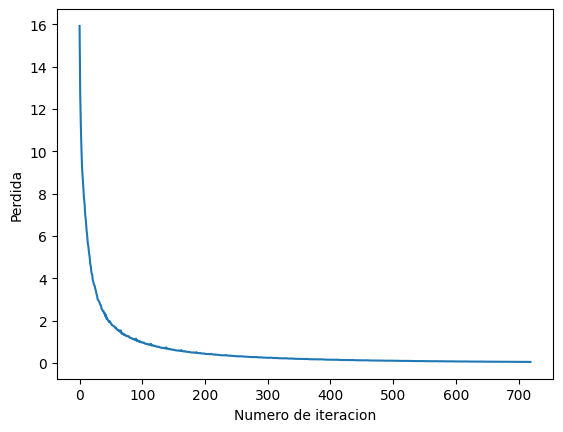

In [13]:
# Grafica la evolucion de la perdida con cada iteracion
def graficarPerdida(Loss):
    plt.figure()
    iteracion = range(len(Loss))
    plt.plot(iteracion, Loss)
    plt.xlabel("Numero de iteracion")
    plt.ylabel("Perdida")

graficarPerdida(Loss)

La gráfica de la pérdida tiene picos muy sutiles y en general desciende de manera suave. Esto sucede así porque en el entrenamiento se realizan cubrimientos de una misma partición de los datos. 

En la gráfica también se puede ver que a partir de la iteración 500 la pérdida llega a estabilizarse quedando muy cerca del 0. Por esta razón ya no es necesario seguir haciendo más iteraciones de descenso del gradiente.

##
Programe un función redna en Python que use el método del gradiente descendiente, tomando subconjuntos aleatorios (bunch o batch) de tamaño 50 en cada iteración, para encontrar el conjunto de pesos que minimizan $E_p$ . Realice experimentos variando el número máximo de iteraciones hasta conseguir porcentaje de imágenes bien clasificadas mayores o iguales al 90% en cada clase sobre el conjunto de entrenamiento. La función debe devolver los pesos, el vector de pérdida total en cada iteración y graficar la función de perdida de manera dinámica (hacer el gráfico en cada iteración).

In [14]:
# Ajusta los parametros de la red mediante descenso de gradiente
def redna(X, Y, numParam, sizeBunch = 50, nmax = 400, step = 0.01, standarize = False, dynamicGraph = True):
    # Genero pesos aleatorios
    W = np.random.normal(size = numParam) 
    # Inicializo la perdida
    Loss = []   
    # Ciclo de busqueda
    for i in range(nmax) :
        # Genero el bunch aleatorio
        ind = np.arange(0, len(Y), dtype=int)
        ind = np.random.permutation(ind)
        bunch = ind[0:sizeBunch]
        # Capacidad interpretacion
        Z = np.matmul(W, np.transpose(X))
        # Estandarizo de ser necesario para evitar overflows
        if(standarize):
            Z = (Z - np.mean(Z))/ np.std(Z) * 3
        # Probabilidades obtenidas en softmax
        P = msoft(Z)
        # Gradiente
        grad = mgrad(X[bunch, :], Y[bunch, :], P[:, bunch])
        # Actualizo pesos
        W = W - step *  grad 
        # Calculo perdida en la iteracion
        Loss.append(entropiaCruzada(P, Y))
        # Actualizacion dinamica del grafico
        if(dynamicGraph):
            # Genero la nueva linea
            line = plt.plot(range(len(Loss)), Loss)
            # Muestro en pantalla el grafico
            display.display(plt.gcf())
            # Borro el output para mostrar un nuevo grafico
            display.clear_output(wait = True)
            # Elimino la linea del stack de plots
            line.pop(0).remove()
            
    plt.plot(range(len(Loss)), Loss)
    probarClasificacion(P, Y)
    return(W, Loss)   

Se clasificaron bien el 98.0% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 98.35% 
Porcentaje de la clase 0 mal clasificados:  1.65% 

Porcentaje de la clase 1 bien clasificados: 98.36% 
Porcentaje de la clase 1 mal clasificados:  1.64% 

Porcentaje de la clase 2 bien clasificados: 99.14% 
Porcentaje de la clase 2 mal clasificados:  0.86% 

Porcentaje de la clase 3 bien clasificados: 97.58% 
Porcentaje de la clase 3 mal clasificados:  2.42% 

Porcentaje de la clase 4 bien clasificados: 98.35% 
Porcentaje de la clase 4 mal clasificados:  1.65% 

Porcentaje de la clase 5 bien clasificados: 100.0% 
Porcentaje de la clase 5 mal clasificados:  0.0% 

Porcentaje de la clase 6 bien clasificados: 99.22% 
Porcentaje de la clase 6 mal clasificados:  0.78% 

Porcentaje de la clase 7 bien clasificados: 98.37% 
Porcentaje de la clase 7 mal clasificados:  1.63% 

Porcentaje de la clase 8 bien clasificados: 96.61% 
Porcentaje de la clase 8 mal clasificados:  

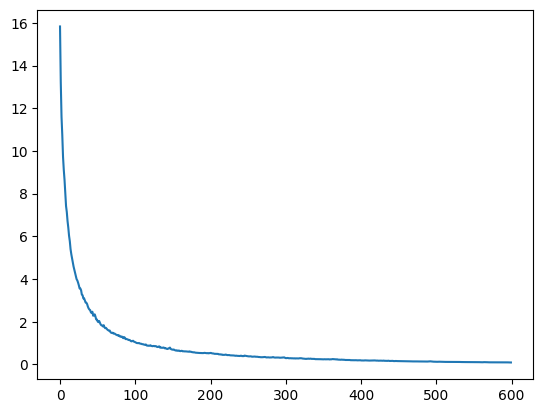

In [15]:
# Entreno el modelo
W, Loss = redna(XTrain, YTrain, (10, 257), sizeBunch = 50, nmax = 600, step = 0.01, dynamicGraph = False)
# Cambiar dynamicGraph a True para generar el gráfico de la perdida de forma dinamica
# No es recomendable usar dynamicGraph con nmax mayor a 100

En este caso se obtuvo una clasificación exitosa del 98% de las imágenes, que es ligeramente menor al obtenido en el literal anterior. 

Al usar bunchs aleatorios en cada iteracion se esperaría tener mas saltos en el algoritmo de descenso de gradiente. Sin embargo, la gráfica de pérdida es muy similar a la hallada con la función *redn*.

##
Utilice los pesos obtenidos en el numeral anterior para predecir la clase correspondiente sobre el conjunto de datos de prueba, reporte el porcentaje de bien clasificados por el modelo en cada clase, también reporte los porcentajes de mal clasificados en cada clase (validación cruzada).

In [16]:
# Probabilidad generada por el modelo sobre las imagenes de prueba (test)
ZTest = np.matmul(W, np.transpose(XTest))
PTest = msoft(ZTest)
probarClasificacion(PTest, YTest)

Se clasificaron bien el 83.42% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 94.87% 
Porcentaje de la clase 0 mal clasificados:  5.13% 

Porcentaje de la clase 1 bien clasificados: 82.5% 
Porcentaje de la clase 1 mal clasificados:  17.5% 

Porcentaje de la clase 2 bien clasificados: 83.72% 
Porcentaje de la clase 2 mal clasificados:  16.28% 

Porcentaje de la clase 3 bien clasificados: 74.29% 
Porcentaje de la clase 3 mal clasificados:  25.71% 

Porcentaje de la clase 4 bien clasificados: 80.0% 
Porcentaje de la clase 4 mal clasificados:  20.0% 

Porcentaje de la clase 5 bien clasificados: 84.31% 
Porcentaje de la clase 5 mal clasificados:  15.69% 

Porcentaje de la clase 6 bien clasificados: 100.0% 
Porcentaje de la clase 6 mal clasificados:  0.0% 

Porcentaje de la clase 7 bien clasificados: 88.57% 
Porcentaje de la clase 7 mal clasificados:  11.43% 

Porcentaje de la clase 8 bien clasificados: 75.68% 
Porcentaje de la clase 8 mal clasificados

La capacidad de generalización del modelo *redna* presenta los mismos problemas que la *redn*

##
Repita los numerales desde el dos hasta el siete para los datos mnist de entrenamiento y de prueba dados. Haga iteraciones con subconjuntos de tamaño 500 y 50 épocas, en el caso aleatorio tome conjuntos de tamaño 500 también.


In [17]:
# 8.2 La funcion de perdida y su gradiente son los mismos de antes

In [18]:
# 8.3
# Cargo los datos
mnistTrain = np.array(pd.read_csv('./data/mnist_train.csv'))
mnistTest = np.array(pd.read_csv('./data/mnist_test.csv'))

In [19]:
# Guardo el tensor X (con un bias) y las labels Y de Train
XTrain = np.c_[mnistTrain[:,1:], np.ones(60000)]
LabelsTrain = mnistTrain[:,0]

# Guardo el tensor X (con un bias) y las labels Y de Test
XTest = np.c_[mnistTest[:,1:], np.ones(10000)]
LabelsTest = mnistTest[:,0]

# Genero las variables dummies
YTrain = np.zeros((60000, 10))
for i in range(60000):
    lab = LabelsTrain[i]
    YTrain[i, lab] = 1

YTest = np.zeros((10000, 10))
for i in range(10000):
    lab = LabelsTest[i]
    YTest[i, lab] = 1

In [20]:
# Entreno la red
W, Loss = redn(XTrain, YTrain, (10, 785), sizeBunch = 500, numEpoch = 5, step = 0.01, standarize = True)

Se clasificaron bien el 90.57% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 96.76% 
Porcentaje de la clase 0 mal clasificados:  3.24% 

Porcentaje de la clase 1 bien clasificados: 97.14% 
Porcentaje de la clase 1 mal clasificados:  2.86% 

Porcentaje de la clase 2 bien clasificados: 85.95% 
Porcentaje de la clase 2 mal clasificados:  14.05% 

Porcentaje de la clase 3 bien clasificados: 90.23% 
Porcentaje de la clase 3 mal clasificados:  9.77% 

Porcentaje de la clase 4 bien clasificados: 91.75% 
Porcentaje de la clase 4 mal clasificados:  8.25% 

Porcentaje de la clase 5 bien clasificados: 80.15% 
Porcentaje de la clase 5 mal clasificados:  19.85% 

Porcentaje de la clase 6 bien clasificados: 95.08% 
Porcentaje de la clase 6 mal clasificados:  4.92% 

Porcentaje de la clase 7 bien clasificados: 91.24% 
Porcentaje de la clase 7 mal clasificados:  8.76% 

Porcentaje de la clase 8 bien clasificados: 86.74% 
Porcentaje de la clase 8 mal clasificado

El único cambio que tiene la funcion *redn* para clasificar las imagenes de Mnist en lugar de Semeion es que se requiere estandarizar la capacidad de interpretación Z. Esto se hace para evitar overflows al momento de pasar por la función *msoft*. También se decidió multiplicar a Z por un pequeño factor de escalamiento luego de estandarizar con el objetivo de que el gradiente no se desvanezca.

Se realizaron varias pruebas y se halló que a partir de 5 épocas la mejora en la optimización de la función de pérdida era mínima. Se obtuvo un porcentaje de imagenes de prueba bien clasificadas de 90%, que es menor al obtenido usando los datos de Semeion. Esto se debe a que la cantidad de imágenes en Mnist es mucho mayor, al igual que el número de atributos (pixeles) por imagen. Ambas cosas aportan a que sea más complicado alcanzar un mínimo global de la función de pérdida.

In [21]:
# 8.4
# Clasificacion del modelo sobre las imagenes de prueba (test)
ZTest = np.matmul(W, np.transpose(XTest))
ZTest = (ZTest - np.mean(ZTest))/ np.std(ZTest)
PTest = msoft(ZTest)
probarClasificacion(PTest, YTest)

Se clasificaron bien el 91.06% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 98.47% 
Porcentaje de la clase 0 mal clasificados:  1.53% 

Porcentaje de la clase 1 bien clasificados: 97.62% 
Porcentaje de la clase 1 mal clasificados:  2.38% 

Porcentaje de la clase 2 bien clasificados: 86.24% 
Porcentaje de la clase 2 mal clasificados:  13.76% 

Porcentaje de la clase 3 bien clasificados: 91.19% 
Porcentaje de la clase 3 mal clasificados:  8.81% 

Porcentaje de la clase 4 bien clasificados: 92.67% 
Porcentaje de la clase 4 mal clasificados:  7.33% 

Porcentaje de la clase 5 bien clasificados: 83.3% 
Porcentaje de la clase 5 mal clasificados:  16.7% 

Porcentaje de la clase 6 bien clasificados: 93.95% 
Porcentaje de la clase 6 mal clasificados:  6.05% 

Porcentaje de la clase 7 bien clasificados: 90.27% 
Porcentaje de la clase 7 mal clasificados:  9.73% 

Porcentaje de la clase 8 bien clasificados: 85.93% 
Porcentaje de la clase 8 mal clasificados:

En este caso, el porcentaje de imágenes bien clasificadas en test superó incluso al porcentaje obtenido en el entrenamiento. Esto quiere decir que la red neuronal entrenada sobre Mnist tiene una mayor capacidad de generalización que la red entrenada con Semeion. La razón es que se contó con más información de los inputs en forma de más instancias y atributos por instancia.

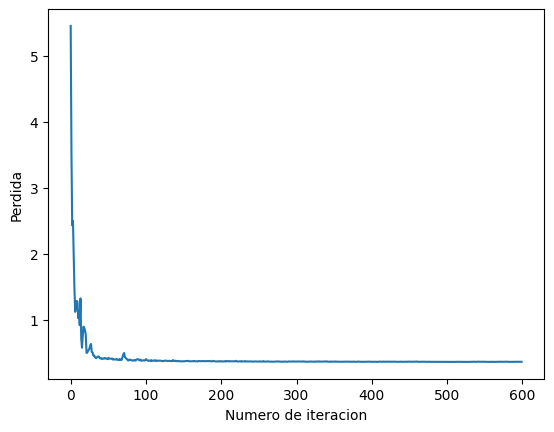

In [22]:
# 8.5
graficarPerdida(Loss)

La gráfica de la pérdida es mucho más irregular en la red entrenada sobre Mnist. Al tener un conjunto de entrenamiento más grande puede suceder que en alguna iteración de descenso de gradiente el bunch seleccionado no sea representativo de todo el conjunto de datos. Esto provoca que el cambio en el gradiente que favorece a las imágenes del bunch favorezca en menor medida la función de pérdida global

También se observa que la pérdida se acerca a 0 mucho más rápido, lo cual puede deberse a que se están utilizando bunchs más grandes que a su vez generan pasos del gradiente mayores.

Se clasificaron bien el 90.64% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 96.45% 
Porcentaje de la clase 0 mal clasificados:  3.55% 

Porcentaje de la clase 1 bien clasificados: 97.05% 
Porcentaje de la clase 1 mal clasificados:  2.95% 

Porcentaje de la clase 2 bien clasificados: 86.56% 
Porcentaje de la clase 2 mal clasificados:  13.44% 

Porcentaje de la clase 3 bien clasificados: 88.65% 
Porcentaje de la clase 3 mal clasificados:  11.35% 

Porcentaje de la clase 4 bien clasificados: 93.2% 
Porcentaje de la clase 4 mal clasificados:  6.8% 

Porcentaje de la clase 5 bien clasificados: 84.32% 
Porcentaje de la clase 5 mal clasificados:  15.68% 

Porcentaje de la clase 6 bien clasificados: 95.07% 
Porcentaje de la clase 6 mal clasificados:  4.93% 

Porcentaje de la clase 7 bien clasificados: 91.46% 
Porcentaje de la clase 7 mal clasificados:  8.54% 

Porcentaje de la clase 8 bien clasificados: 84.98% 
Porcentaje de la clase 8 mal clasificados

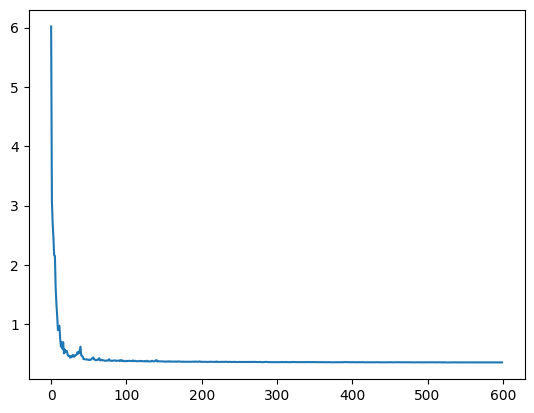

In [23]:
# 8.6
W, Loss = redna(XTrain, YTrain, (10, 785), sizeBunch = 500, nmax = 600, step = 0.01, standarize = True, dynamicGraph = False)

Con la *redna* entrenada sobre el dataset Mnist se hace la misma estandarización de los valores de Z para evitar overflows.

Los resultados de usar bunchs aleatorios en cada iteración son muy parecidos a los obtenidos usando una única partición. El único cambio es que los picos de la pérdida son más pronunciados.

In [24]:
# 8.7
# Probabilidad generada por el modelo sobre las imagenes de prueba (test)
ZTest = np.matmul(W, np.transpose(XTest))
ZTest = (ZTest - np.mean(ZTest))/ np.std(ZTest)
PTest = msoft(ZTest)
probarClasificacion(PTest, YTest)


Se clasificaron bien el 91.05% de todas las imagenes

Validacion cruzada:
Porcentaje de la clase 0 bien clasificados: 97.65% 
Porcentaje de la clase 0 mal clasificados:  2.35% 

Porcentaje de la clase 1 bien clasificados: 97.44% 
Porcentaje de la clase 1 mal clasificados:  2.56% 

Porcentaje de la clase 2 bien clasificados: 86.05% 
Porcentaje de la clase 2 mal clasificados:  13.95% 

Porcentaje de la clase 3 bien clasificados: 90.2% 
Porcentaje de la clase 3 mal clasificados:  9.8% 

Porcentaje de la clase 4 bien clasificados: 92.97% 
Porcentaje de la clase 4 mal clasificados:  7.03% 

Porcentaje de la clase 5 bien clasificados: 84.98% 
Porcentaje de la clase 5 mal clasificados:  15.02% 

Porcentaje de la clase 6 bien clasificados: 94.68% 
Porcentaje de la clase 6 mal clasificados:  5.32% 

Porcentaje de la clase 7 bien clasificados: 91.05% 
Porcentaje de la clase 7 mal clasificados:  8.95% 

Porcentaje de la clase 8 bien clasificados: 86.14% 
Porcentaje de la clase 8 mal clasificados:

Nuevamente la generalización de la red neuronal demuestra ser mejor al usar Mnist para el entrenamiento en lugar de Semeion.